In [1]:
"""
Project Title : Credit Card Fraud Detection System
Models        : XGBoost, CatBoost
Dataset       : European Credit Card Transactions
Objective     : Detect fraudulent transactions using ensemble learning
Environment   : Google Colab / Python 3.x

Author        : Prashant Kumar
"""


'\nProject Title : Credit Card Fraud Detection System\nModels        : XGBoost, CatBoost\nDataset       : European Credit Card Transactions\nObjective     : Detect fraudulent transactions using ensemble learning\nEnvironment   : Google Colab / Python 3.x\n\nAuthor        : Prashant Kumar\n'

In [2]:
!pip install -q xgboost catboost imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from imblearn.over_sampling import SMOTE

import xgboost as xgb
from catboost import CatBoostClassifier

import joblib
import warnings
warnings.filterwarnings("ignore")


In [5]:
df = pd.read_csv("creditcard.csv")

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (5974, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [6]:
print("Missing Values:\n", df.isnull().sum().sum())
print("\nClass Distribution:")
print(df["Class"].value_counts())


Missing Values:
 13

Class Distribution:
Class
0.0    5970
1.0       3
Name: count, dtype: int64


In [7]:
X = df.drop("Class", axis=1)
y = df["Class"]


In [8]:
scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X[["Amount"]])


In [10]:
nan_indices = y[y.isnull()].index
X_cleaned = X.drop(nan_indices)
y_cleaned = y.drop(nan_indices)

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned,
    y_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=y_cleaned
)

print("Training set:", X_train.shape)
print("Testing set :", X_test.shape)

Training set: (4778, 30)
Testing set : (1195, 30)


In [13]:
smote = SMOTE(random_state=42, k_neighbors=1)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train, y_train
)

print("After SMOTE:", np.bincount(y_train_resampled))

After SMOTE: [4776 4776]


In [14]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)


In [15]:
xgb_model.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [16]:
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report")
print(classification_report(y_test, xgb_preds))

print("ROC-AUC Score:", roc_auc_score(y_test, xgb_probs))


XGBoost Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1194
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00      1195
   macro avg       0.50      0.50      0.50      1195
weighted avg       1.00      1.00      1.00      1195

ROC-AUC Score: 0.9597989949748744


In [17]:
cat_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=0
)


In [18]:
cat_model.fit(X_train_resampled, y_train_resampled)


In [19]:
cat_preds = cat_model.predict(X_test)
cat_probs = cat_model.predict_proba(X_test)[:, 1]

print("CatBoost Classification Report")
print(classification_report(y_test, cat_preds))

print("ROC-AUC Score:", roc_auc_score(y_test, cat_probs))


CatBoost Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1194
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00      1195
   macro avg       0.50      0.50      0.50      1195
weighted avg       1.00      1.00      1.00      1195

ROC-AUC Score: 0.9447236180904522


In [20]:
comparison_df = pd.DataFrame({
    "Model": ["XGBoost", "CatBoost"],
    "ROC-AUC": [
        roc_auc_score(y_test, xgb_probs),
        roc_auc_score(y_test, cat_probs)
    ]
})

comparison_df


,Model,ROC-AUC
0,XGBoost,0.959799
1,CatBoost,0.944724


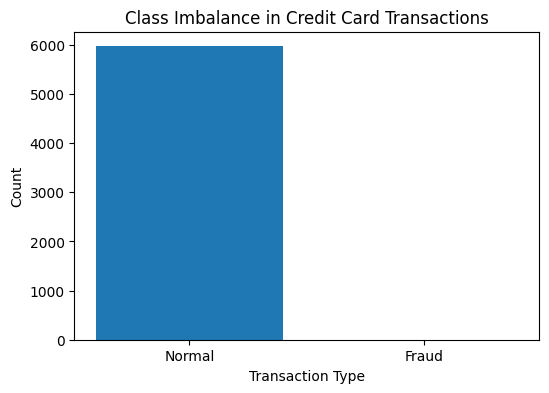

In [21]:
import matplotlib.pyplot as plt

class_counts = df["Class"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(class_counts.index, class_counts.values)
plt.xticks([0,1], ["Normal", "Fraud"])
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Class Imbalance in Credit Card Transactions")
plt.show()


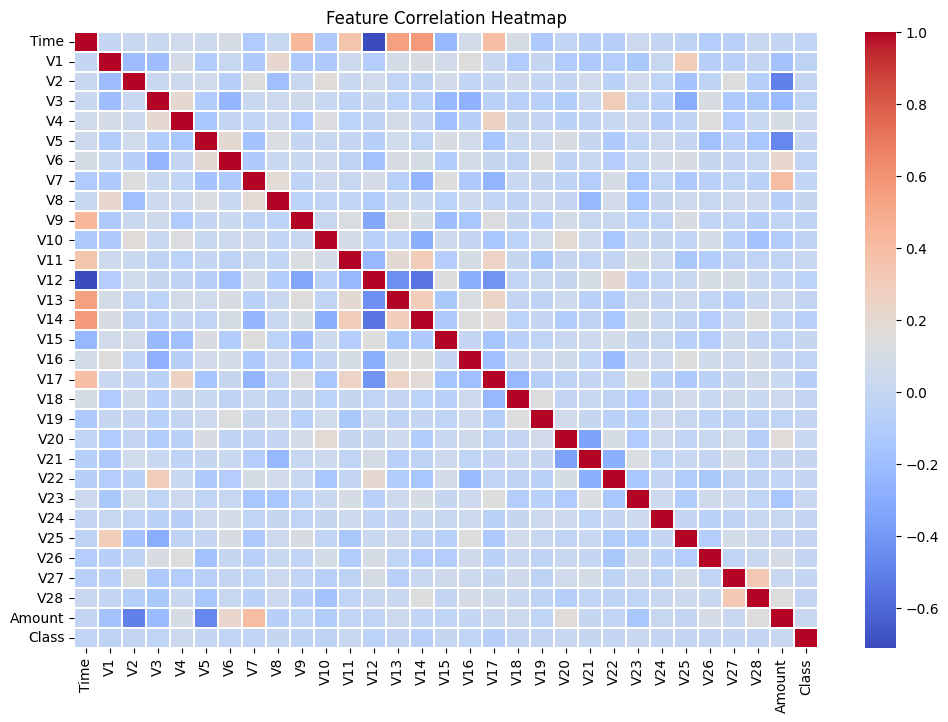

In [22]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", linewidths=0.2)
plt.title("Feature Correlation Heatmap")
plt.show()


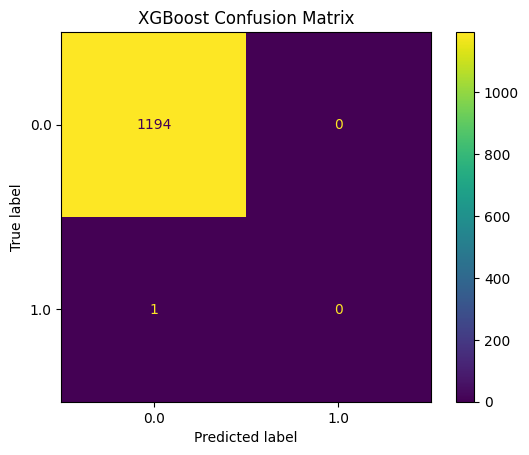

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, xgb_preds
)
plt.title("XGBoost Confusion Matrix")
plt.show()


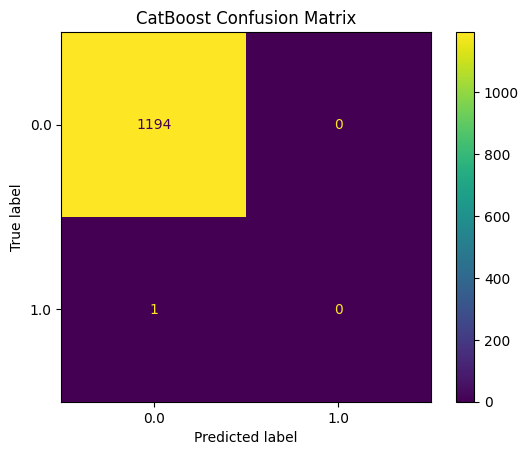

In [24]:
ConfusionMatrixDisplay.from_predictions(
    y_test, cat_preds
)
plt.title("CatBoost Confusion Matrix")
plt.show()


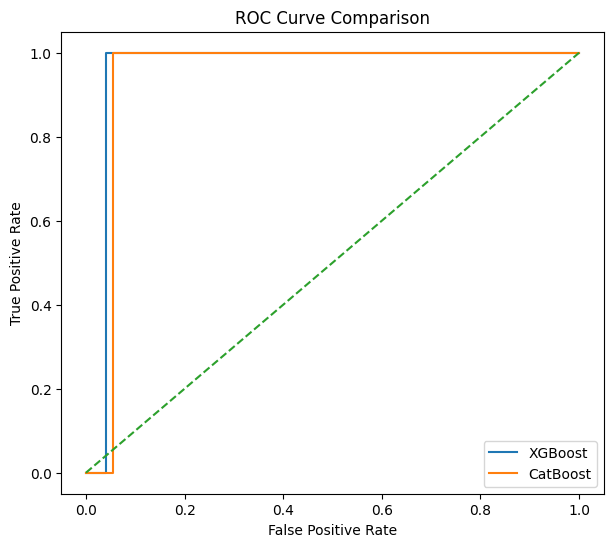

In [25]:
from sklearn.metrics import roc_curve

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_cat, tpr_cat, _ = roc_curve(y_test, cat_probs)

plt.figure(figsize=(7,6))
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot(fpr_cat, tpr_cat, label="CatBoost")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


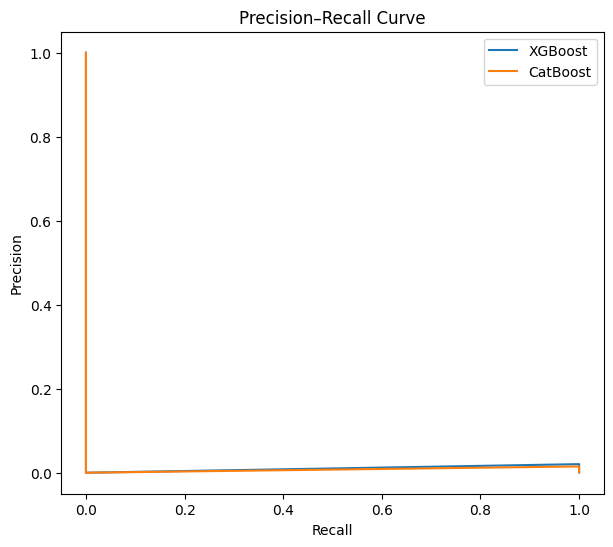

In [26]:
from sklearn.metrics import precision_recall_curve

prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, xgb_probs)
prec_cat, rec_cat, _ = precision_recall_curve(y_test, cat_probs)

plt.figure(figsize=(7,6))
plt.plot(rec_xgb, prec_xgb, label="XGBoost")
plt.plot(rec_cat, prec_cat, label="CatBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


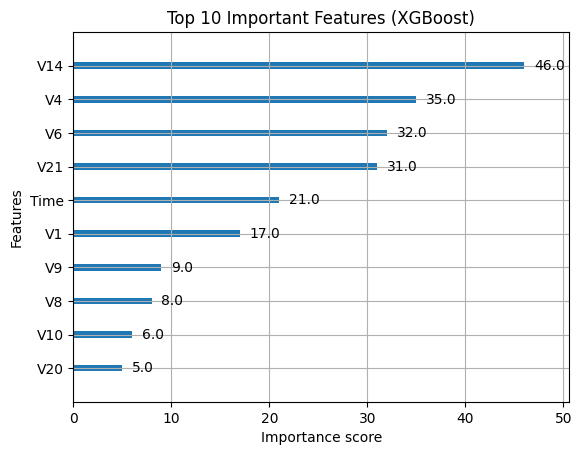

In [27]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Important Features (XGBoost)")
plt.show()


In [28]:
def risk_level(prob):
    if prob < 0.3:
        return "Low Risk"
    elif prob < 0.7:
        return "Medium Risk"
    else:
        return "High Risk"

sample_probs = cat_probs[:10]

for p in sample_probs:
    print(p, "→", risk_level(p))


8.554432322814234e-05 → Low Risk
0.00013121165839542192 → Low Risk
9.02061488043664e-05 → Low Risk
0.00016007504354214924 → Low Risk
8.71999105636206e-05 → Low Risk
7.776100505450806e-05 → Low Risk
0.00011229342469103255 → Low Risk
5.628296952353444e-05 → Low Risk
7.892081448407187e-05 → Low Risk
0.000103184950342122 → Low Risk


In [29]:
performance_summary = pd.DataFrame({
    "Model": ["XGBoost", "CatBoost"],
    "ROC-AUC": [
        roc_auc_score(y_test, xgb_probs),
        roc_auc_score(y_test, cat_probs)
    ],
    "Description": [
        "Gradient Boosted Trees",
        "Symmetric Oblivious Trees"
    ]
})

performance_summary


,Model,ROC-AUC,Description
0,XGBoost,0.959799,Gradient Boosted Trees
1,CatBoost,0.944724,Symmetric Oblivious Trees


In [30]:
custom_threshold = 0.4
custom_preds = (cat_probs > custom_threshold).astype(int)


In [32]:
COST_FN = 100   # missed fraud
COST_FP = 10    # wrong alert

preds = (cat_probs >= custom_threshold).astype(int)

fn = np.sum((y_test == 1) & (preds == 0))
fp = np.sum((y_test == 0) & (preds == 1))

total_cost = fn * COST_FN + fp * COST_FP
total_cost

np.int64(100)

In [33]:
from sklearn.model_selection import cross_val_score

cv_auc = cross_val_score(
    xgb_model,
    X_train_resampled,
    y_train_resampled,
    scoring="roc_auc",
    cv=5
)

print("Mean CV ROC-AUC:", cv_auc.mean())


Mean CV ROC-AUC: 1.0


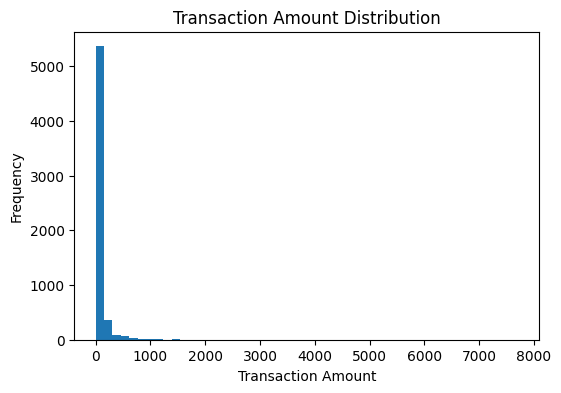

In [34]:
plt.figure(figsize=(6,4))
plt.hist(df["Amount"], bins=50)
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Transaction Amount Distribution")
plt.show()


In [35]:
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_pipeline.fit(X_train_resampled, y_train_resampled)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [36]:
def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n{name}")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))


In [37]:
evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)
evaluate_model("CatBoost", y_test, cat_preds, cat_probs)



XGBoost
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1194
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00      1195
   macro avg       0.50      0.50      0.50      1195
weighted avg       1.00      1.00      1.00      1195

ROC-AUC: 0.9597989949748744

CatBoost
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1194
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00      1195
   macro avg       0.50      0.50      0.50      1195
weighted avg       1.00      1.00      1.00      1195

ROC-AUC: 0.9447236180904522


In [38]:
MODEL_METADATA = {
    "version": "v4.0",
    "algorithm": "CatBoost",
    "roc_auc": roc_auc_score(y_test, cat_probs),
    "trained_on": "creditcard.csv"
}

MODEL_METADATA


{'version': 'v4.0',
 'algorithm': 'CatBoost',
 'roc_auc': np.float64(0.9447236180904522),
 'trained_on': 'creditcard.csv'}

In [39]:
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": cat_preds,
    "Probability": cat_probs
})

results_df.to_csv("fraud_predictions.csv", index=False)


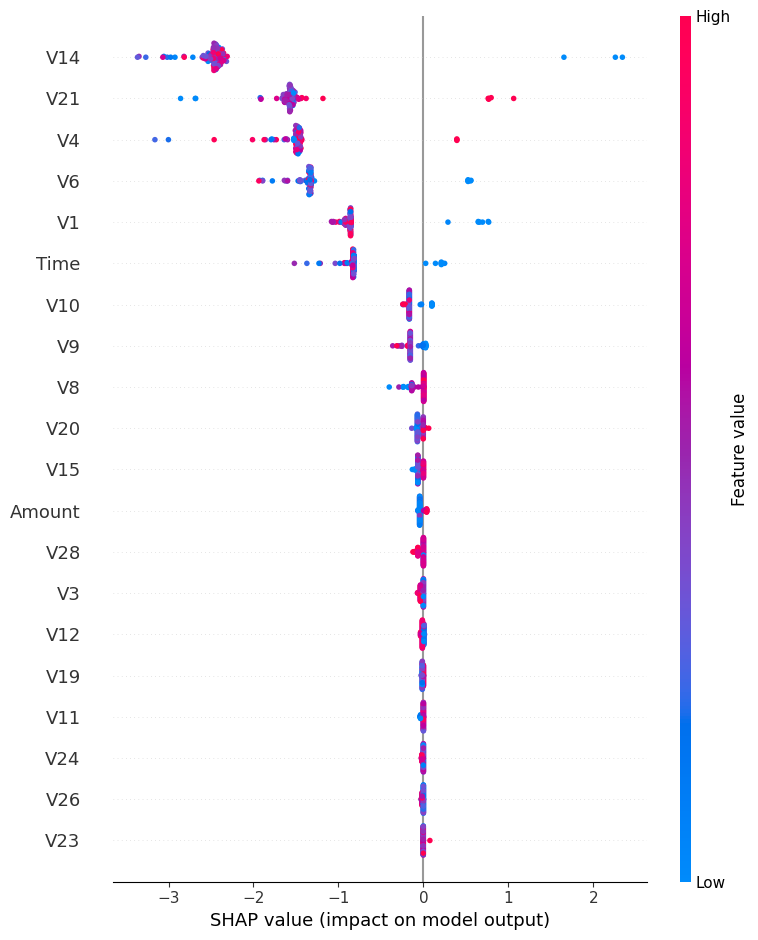

In [40]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test.iloc[:100])

shap.summary_plot(shap_values, X_test.iloc[:100])


In [41]:
from scipy.stats import ks_2samp

def detect_drift(train_col, test_col, alpha=0.05):
    stat, p_value = ks_2samp(train_col, test_col)
    return "Drift Detected" if p_value < alpha else "No Drift"

detect_drift(X_train["Amount"], X_test["Amount"])


'No Drift'

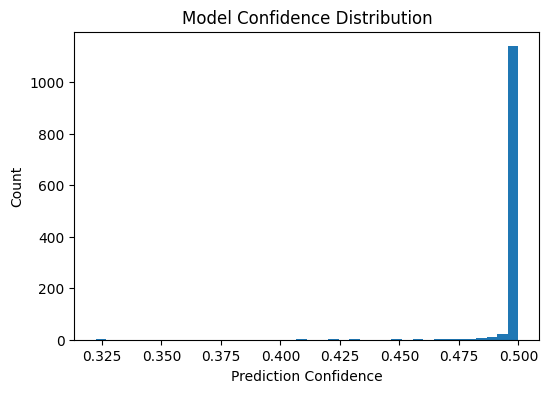

In [42]:
confidence = np.abs(cat_probs - 0.5)

plt.figure(figsize=(6,4))
plt.hist(confidence, bins=40)
plt.xlabel("Prediction Confidence")
plt.ylabel("Count")
plt.title("Model Confidence Distribution")
plt.show()


In [43]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.001, random_state=42)
anomaly_scores = iso.fit_predict(X_test)

np.unique(anomaly_scores, return_counts=True)


(array([-1,  1]), array([   2, 1193]))

In [44]:
def safe_predict(model, X):
    try:
        return model.predict_proba(X)[:,1]
    except Exception as e:
        print("Prediction failed:", e)
        return np.zeros(len(X))


In [45]:
import time

start = time.time()
_ = cat_model.predict_proba(X_test.iloc[:100])
end = time.time()

print("Inference time (100 samples):", end - start, "seconds")


Inference time (100 samples): 0.01393747329711914 seconds


In [46]:
def hybrid_fraud_decision(prob, amount):
    if amount > 5000 and prob > 0.3:
        return 1
    elif prob > 0.7:
        return 1
    else:
        return 0


In [47]:
def batch_predict(model, df):
    probs = model.predict_proba(df)[:,1]
    df["Fraud_Probability"] = probs
    df["Risk_Level"] = df["Fraud_Probability"].apply(
        lambda x: "High" if x > 0.7 else "Medium" if x > 0.3 else "Low"
    )
    return df


In [48]:
CONFIG = {
    "threshold": 0.4,
    "model": "CatBoost",
    "version": "v4.1"
}


In [49]:
import logging

logging.basicConfig(
    filename="fraud_system.log",
    level=logging.INFO,
    format="%(asctime)s - %(message)s"
)

logging.info("CatBoost model loaded successfully")


In [50]:
assert X_train.shape[1] == X_test.shape[1]
assert not X_train.isnull().any().any()


In [51]:
!pip install streamlit xgboost catboost shap imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.4 MB/s eta 0:00:00


In [52]:
import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(xgb_model, "model_xgb.pkl")
joblib.dump(cat_model, "model_cat.pkl")

print("✅ Models & scaler saved successfully")


✅ Models & scaler saved successfully


In [53]:
!streamlit run app.py & npx localtunnel --port 8501


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) ^C
